In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib

In [3]:
import os
import logging
import argparse
import glob
import json
from collections import Counter

import numpy as np
from matplotlib.ticker import StrMethodFormatter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown

from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config
from zoobot import label_metadata
from zoobot.estimators import losses, dirichlet_stats


In [4]:
os.chdir('/home/walml/repos/zoobot')

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)


In [6]:
# catalog_loc = 'data/gz2/gz2_master_catalog.csv'
# catalog = pd.read_csv(catalog_loc, dtype={'subject_id': str})  # original catalog
# catalog['file_loc'] = catalog['local_png_loc'].apply(lambda x: '/media/walml/beta/galaxy_zoo/gz2' + x[32:])
# catalog['id_str'] = catalog['dr7objid'].apply(lambda x: 'dr7objid_' + str(x))


catalog_loc = 'data/decals/decals_master_catalog.csv'
catalog = pd.read_csv(catalog_loc, dtype={'subject_id': str})  # original catalog
# catalog['file_loc'] = catalog['local_png_loc'].apply(lambda x: '/media/walml/beta/gz2' + x[32:])
catalog['file_loc'] = catalog['local_png_loc'].apply(lambda x: '/media/walml/beta/decals' + x.replace('/data/phys-zooniverse/chri5177', ''))
# retired = catalog[catalog['smooth-or-featured_total-votes'] > 35]


In [7]:
# label_cols = label_metadata.gz2_label_cols
# questions = label_metadata.gz2_questions

# label_cols = label_metadata.gz2_partial_label_cols
# questions = label_metadata.gz2_partial_questions
# version = 'gz2'


label_cols = label_metadata.decals_label_cols
questions = label_metadata.decals_questions
version = 'decals'

schema = losses.Schema(label_cols, questions, version=version)

{smooth-or-featured, indices 0 to 2, asked after None: (0, 2), disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1: (3, 4), has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4: (5, 6), bar, indices 7 to 9, asked after disk-edge-on_no, index 4: (7, 9), bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4: (10, 14), how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0: (15, 17), edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3: (18, 20), spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5: (21, 23), spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5: (24, 29), merging, indices 30 to 33, asked after None: (30, 33)}


In [8]:
concentration_cols = [col + '_concentration' for col in label_cols]
concentration_mean_cols = [col + '_concentration_mean' for col in label_cols]

# for it in it_list:
#     for col in concentration_cols:
#         it[col] = it[col].apply(lambda x: np.array(json.loads(x)))

In [9]:
m = 0
n_models = 1  # important

# optimise spiral, predict 4q
# active_locs = [f'temp/gz2_1q_conc_active_it2_m{n}.csv' for n in range(n_models)]
# baseline_locs = [f'temp/gz2_1q_conc_baseline_it2_m{n}.csv' for n in range(n_models)]


# optimise smooth/feat, predict 1q

# active_locs = [f'temp/gz2_1q_1active_it0_m{n}.csv' for n in range(n_models)]
# baseline_locs = [f'temp/gz2_1q_1baseline_it0_m{n}.csv' for n in range(n_models)]

# active_locs = [f'temp/gz2_1q_1active_it1_m{n}.csv' for n in range(n_models)]
# baseline_locs = [f'temp/gz2_1q_1baseline_it1_m{n}.csv' for n in range(n_models)]

# active_locs = [f'temp/gz2_1q_1active_it2_m{n}.csv' for n in range(n_models)]
# baseline_locs = [f'temp/gz2_1q_1baseline_it2_m{n}.csv' for n in range(n_models)]

# active_locs = [f'temp/gz2_1q_1active_it2_m{n}_log.csv' for n in range(n_models)]
# baseline_locs = [f'temp/gz2_1q_1baseline_it2_m{n}_log.csv' for n in range(n_models)]

# baseline_locs = [f'temp/gz2_1q_1baseline_it1_m{n}_log.csv' for n in range(n_models)]
# active_locs = [f'temp/gz2_1q_1active_best_it1_m{n}.csv' for n in range(n_models)]
# active_dfs = [pd.read_csv(loc) for loc in active_locs]
# baseline_dfs = [pd.read_csv(loc) for loc in baseline_locs]

df_a = pd.read_csv('results/decals_dr_full_m0_eval_predictions.csv')  # .1-20
# df_a = pd.read_csv('results/decals_dr_full_reparam_eval_predictions.csv')
df_b = pd.read_csv('results/decals_dr_full_1_to_100_eval_predictions.csv')  # better at all questions than .1-20, in this case

active_dfs = [df_a]
baseline_dfs = [df_b]



In [10]:
active_concentrations = [dirichlet_stats.load_all_concentrations(df, concentration_cols) for df in active_dfs]
baseline_concentrations = [dirichlet_stats.load_all_concentrations(df, concentration_cols) for df in baseline_dfs]

In [11]:
answer_cols = [a.text for a in schema.answers]
labels = active_dfs[0][answer_cols].values  # same for all

In [12]:
labels.shape

(49700, 34)

In [13]:
active_concentrations[0].shape

(49700, 34, 5)

In [14]:
active_concentrations_combined = np.concatenate(active_concentrations, axis=-1)
active_concentrations_combined.shape

(49700, 34, 5)

In [15]:
for model_n in range(n_models):
    single_loss = dirichlet_stats.dirichlet_mixture_loss(labels, active_concentrations[model_n], schema.question_index_groups)
    print(list(zip(questions, single_loss.mean(axis=0))))

[('smooth-or-featured', 2.4208422), ('disk-edge-on', 0.5823309), ('has-spiral-arms', 0.62160194), ('bar', 1.0855035), ('bulge-size', 1.7106684), ('how-rounded', 1.3781377), ('edge-on-bulge', 0.41242525), ('spiral-winding', 0.8165927), ('spiral-arm-count', 1.1861445), ('merging', 2.9442751)]


In [16]:

active_losses = dirichlet_stats.dirichlet_mixture_loss(labels, active_concentrations_combined, schema.question_index_groups)
list(zip(questions, active_losses.mean(axis=0)))

[('smooth-or-featured', 2.4208422),
 ('disk-edge-on', 0.5823309),
 ('has-spiral-arms', 0.62160194),
 ('bar', 1.0855035),
 ('bulge-size', 1.7106684),
 ('how-rounded', 1.3781377),
 ('edge-on-bulge', 0.41242525),
 ('spiral-winding', 0.8165927),
 ('spiral-arm-count', 1.1861445),
 ('merging', 2.9442751)]

In [17]:
baseline_concentrations_combined = np.concatenate(baseline_concentrations, axis=-1)

In [18]:
for model_n in range(n_models):
    baseline_single_loss = dirichlet_stats.dirichlet_mixture_loss(labels, baseline_concentrations[model_n], schema.question_index_groups)
    print(list(zip(questions, baseline_single_loss.mean(axis=0))))

[('smooth-or-featured', 2.3931053), ('disk-edge-on', 0.580685), ('has-spiral-arms', 0.6120071), ('bar', 1.0784818), ('bulge-size', 1.706477), ('how-rounded', 1.3837879), ('edge-on-bulge', 0.4107455), ('spiral-winding', 0.80784), ('spiral-arm-count', 1.1735061), ('merging', 2.892194)]


In [19]:

baseline_losses = dirichlet_stats.dirichlet_mixture_loss(labels, baseline_concentrations_combined, schema.question_index_groups)
list(zip(questions, baseline_losses.mean(axis=0)))

[('smooth-or-featured', 2.3931053),
 ('disk-edge-on', 0.580685),
 ('has-spiral-arms', 0.6120071),
 ('bar', 1.0784818),
 ('bulge-size', 1.706477),
 ('how-rounded', 1.3837879),
 ('edge-on-bulge', 0.4107455),
 ('spiral-winding', 0.80784),
 ('spiral-arm-count', 1.1735061),
 ('merging', 2.892194)]

In [20]:
assert len(active_losses) == len(baseline_losses)

In [21]:
active_like = np.exp(-active_losses)  # inverse of neg log likelihood = 
baseline_like = np.exp(-baseline_losses)

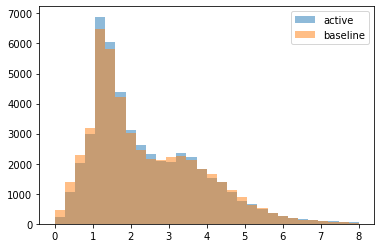

In [22]:
plt.hist(active_losses[:, 0], bins=30, alpha=.5, range=(0., 8.), label='active')
plt.hist(baseline_losses[:, 0], bins=30, alpha=.5, range=(0., 8.), label='baseline')
plt.legend()

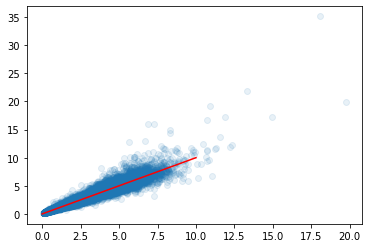

In [23]:
plt.scatter(baseline_losses[:, 0], active_losses[:, 0], alpha=.1)
plt.plot([0., 10], [0., 10.], color='r')

In [24]:
baseline_losses.shape

(49700, 10)

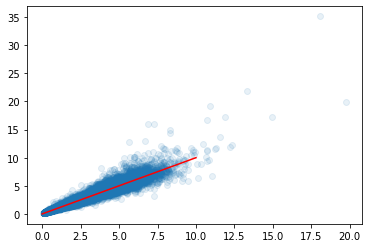

In [25]:
question_n = 0
plt.scatter(baseline_losses[:, question_n], active_losses[:, question_n], alpha=.1)
plt.plot([0., 10], [0., 10.], color='r')

(0.0, 0.5)

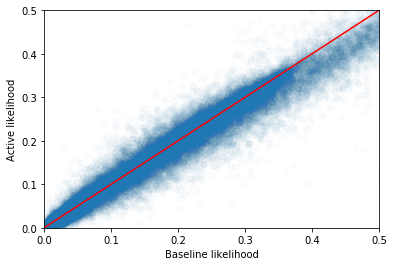

In [26]:
question_n = 0
plt.scatter(baseline_like[:, question_n], active_like[:, question_n], alpha=.02)
plt.xlabel('Baseline likelihood')
plt.ylabel('Active likelihood')
plt.plot([0., 1], [0., 1.], color='r')
plt.xlim(0., .5)
plt.ylim((0., .5))

(0.0, 0.3)

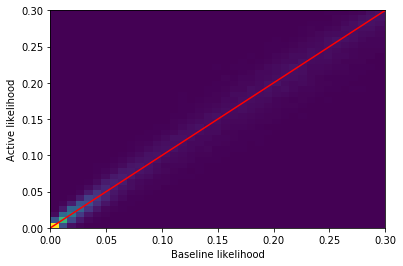

In [27]:
question_n = 0
plt.hist2d(baseline_like[:, question_n], active_like[:, question_n], bins=(120, 120))
plt.xlabel('Baseline likelihood')
plt.ylabel('Active likelihood')
plt.plot([0., 1], [0., 1.], color='r')
plt.xlim(0., .3)
plt.ylim((0., .3))

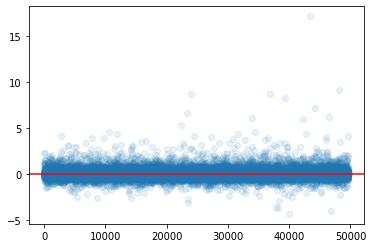

In [28]:
question_n = 0
plt.scatter(np.arange(len(baseline_losses)), active_losses[:, question_n] - baseline_losses[:, question_n], alpha=.1)
plt.axhline(0., color='r')

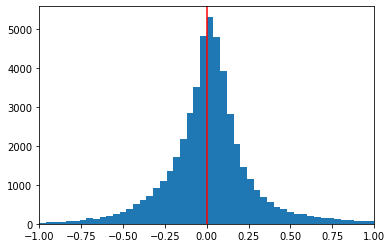

In [29]:
question_n = 0
_ = plt.hist(active_losses[:, question_n] - baseline_losses[:, question_n], range=(-1, 1), bins=50)
plt.xlim(-1, 1)
plt.axvline(0., color='r')

In [30]:
for question_n in range(1):
    print((active_losses[:, question_n] - baseline_losses[:, question_n]).mean())

0.0277466


In [31]:
question_n = 0
delta_loss = active_losses[:, question_n] - baseline_losses[:, question_n]
for window in [0, 2, 5, 10, 20, 30, 40]:
    delta_loss_clipped = np.clip(delta_loss, np.percentile(delta_loss, window), np.percentile(delta_loss, 100 - window))
    print(window, delta_loss_clipped.mean()) 
# negative delta loss = baseline bigger loss than active = active better, and vica versa
# possibly active learning helps more with the hardest galaxies, in exchange for some of the easiest galaxies?
# no, I'm being silly, it's DELTA loss...

0 0.0277466
2 0.021593425
5 0.017561112
10 0.013909197
20 0.013032243
30 0.015426359
40 0.016858043


In [32]:

for window in [0, 2, 5, 10, 20, 30, 40]:
    delta_loss_clipped = np.clip(delta_loss, np.percentile(delta_loss, window), np.percentile(delta_loss, 100 - window))
    print(window, delta_loss_clipped.mean()) 
# negative delta loss = baseline bigger loss than active = active better, and vica versa
# possibly active learning helps more with the hardest galaxies, in exchange for some of the easiest galaxies?
# no, I'm being silly, it's DELTA loss...

0 0.0277466
2 0.021593425
5 0.017561112
10 0.013909197
20 0.013032243
30 0.015426359
40 0.016858043


In [33]:
question_n = 0

In [34]:
results = []
mean_loss = (active_losses[:, question_n] + baseline_losses[:, question_n]) / 2
delta_loss = active_losses[:, question_n] - baseline_losses[:, question_n]
bin_width = 10
for min_pc in np.arange(0, 100, bin_width):
    max_pc = min_pc + bin_width
    print(min_pc, max_pc)
    min_val, max_val = np.percentile(mean_loss, min_pc), np.percentile(mean_loss, max_pc)
    selection = (mean_loss < max_val) & (mean_loss >= min_val)
    
    valid_delta = delta_loss[selection]
    print(min_pc, max_pc, len(valid_delta), valid_delta.mean(), labels[selection][question_n].mean()) 
    results.append((min_pc, max_pc, valid_delta.mean(), labels[selection][question_n].mean(), labels[selection][question_n]))


0 10
0 10 4970 0.0825794 0.35294117647058826
10 20
10 20 4970 0.050987583 0.5294117647058824
20 30
20 30 4970 0.026222315 0.9117647058823529
30 40
30 40 4970 0.020161854 0.8823529411764706
40 50
40 50 4970 0.013343639 1.3529411764705883
50 60
50 60 4970 0.0027974274 0.5882352941176471
60 70
60 70 4970 -0.021607058 1.411764705882353
70 80
70 80 4970 -0.001891026 0.8235294117647058
80 90
80 90 4970 -0.022334235 7.970588235294118
90 100
90 100 4969 0.12378937 8.088235294117647


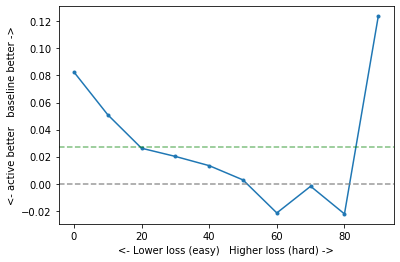

In [35]:
x = [r[0] for r in results]
y = [r[2] for r in results]
plt.plot(x, y, marker='.')
plt.xlabel('<- Lower loss (easy)   Higher loss (hard) ->')
plt.ylabel('<- active better   baseline better ->')
plt.axhline(0., color='grey', alpha=.8, linestyle='--')
plt.axhline(np.mean([r[2] for r in results]), color='g', alpha=.5, linestyle='--')

0 5
0 5 2485 -0.00028094059 10.294117647058824
5 10
5 10 2485 -2.1172307e-05 8.088235294117647
10 15
10 15 2485 0.00032184235 0.3235294117647059
15 20
15 20 2485 0.0005425977 7.970588235294118
20 25
20 25 2485 0.00023155875 0.8235294117647058
25 30
25 30 2485 -5.9839094e-05 2.4411764705882355
30 35
30 35 2485 0.0013463243 1.411764705882353
35 40
35 40 2485 0.0013033091 0.6176470588235294
40 45
40 45 2485 0.0006889218 0.47058823529411764
45 50
45 50 2485 -0.0016650541 0.5882352941176471
50 55
50 55 2485 -0.00227248 1.3529411764705883
55 60
55 60 2485 -0.0025884493 0.5294117647058824
60 65
60 65 2485 -0.0033521364 0.6470588235294118
65 70
65 70 2485 -0.005151978 0.8823529411764706
70 75
70 75 2485 -0.0057332893 1.2941176470588236
75 80
75 80 2485 -0.008744115 0.9117647058823529
80 85
80 85 2485 -0.013000533 0.5294117647058824
85 90
85 90 2485 -0.022934314 0.35294117647058826
90 95
90 95 2485 -0.040194925 0.6176470588235294
95 100
95 100 2484 -0.04828516 0.35294117647058826


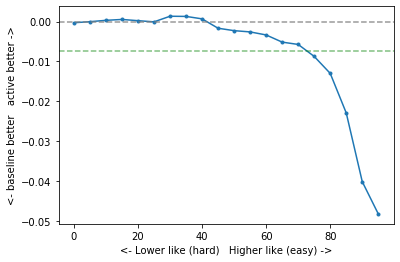

In [36]:
results = []
mean_like = (active_like[:, question_n] + baseline_like[:, question_n]) / 2
delta_like = active_like[:, question_n] - baseline_like[:, question_n]
bin_width = 5
for min_pc in np.arange(0, 100, bin_width):
    max_pc = min_pc + bin_width
    print(min_pc, max_pc)
    min_val, max_val = np.percentile(mean_like, min_pc), np.percentile(mean_like, max_pc)
    selection = (mean_like < max_val) & (mean_like >= min_val)
    
    valid_delta = delta_like[selection]
    print(min_pc, max_pc, len(valid_delta), valid_delta.mean(), labels[selection][question_n].mean()) 
    results.append((min_pc, max_pc, valid_delta.mean(), labels[selection][question_n].mean(), labels[selection][question_n]))

x = [r[0] for r in results]
y = [r[2] for r in results]
plt.plot(x, y, marker='.')
plt.xlabel('<- Lower like (hard)   Higher like (easy) ->')
plt.ylabel('<- baseline better   active better ->')
plt.axhline(0., color='grey', alpha=.8, linestyle='--')
plt.axhline(np.mean([r[2] for r in results]), color='g', alpha=.5, linestyle='--')

In [37]:

results = []
mean_like = (active_like[:, question_n] + baseline_like[:, question_n]) / 2
delta_like = active_like[:, question_n] - baseline_like[:, question_n]
votes = active_dfs[0]['smooth-or-featured_featured-or-disk'].values  # FEATURED votes

bin_width = 10
for min_pc in np.arange(0, 100, bin_width):
    max_pc = min_pc + bin_width
    min_val, max_val = np.percentile(votes, min_pc), np.percentile(votes, max_pc)
    selection = (votes < max_val) & (votes >= min_val)
    print(min_val, max_val)
    print(selection.mean())
    
    valid_delta = delta_like[selection]
#     print(min_pc, max_pc, len(valid_delta), valid_delta.mean(), labels[selection][question_n].mean()) 
    results.append((min_pc, max_pc, valid_delta.mean(), labels[selection][question_n].mean(), labels[selection][question_n]))

x = [r[0] for r in results]
y = [r[2] for r in results]
plt.plot(x, y, marker='.')
plt.xlabel('<- Fewer featured votes   More votes ->')
plt.ylabel('<- baseline better   active better ->')
plt.axhline(0., color='grey', alpha=.8, linestyle='--')
plt.axhline(np.mean([r[2] for r in results]), color='g', alpha=.5, linestyle='--')

0.0 0.0
0.0


/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
question_n = 0
results = []
mean_like = (active_like[:, question_n] + baseline_like[:, question_n]) / 2
delta_like = active_like[:, question_n] - baseline_like[:, question_n]
votes = active_dfs[0]['smooth-or-featured_featured-or-disk'].values

votes_binned = pd.cut(votes, bins=20)
df = pd.DataFrame(data={'votes_binned': votes_binned, 'delta_like': delta_like})
df['votes_center'] = df['votes_binned'].apply(lambda x: x.left + (x.right - x.left)/2)

grouped = df.groupby('votes_center').agg({'delta_like': 'mean'}).reset_index()

sns.lineplot(data=grouped, x='votes_center', y='delta_like', marker='.', markersize=10)

# bin_width = 10
# for min_pc in np.arange(0, 100, bin_width):
#     max_pc = min_pc + bin_width
#     min_val, max_val = np.percentile(votes, min_pc), np.percentile(votes, max_pc)
#     selection = (votes < max_val) & (votes >= min_val)
#     print(min_val, max_val)
#     print(selection.mean())
    
#     valid_delta = delta_like[selection]
# #     print(min_pc, max_pc, len(valid_delta), valid_delta.mean(), labels[selection][question_n].mean()) 
#     results.append((min_pc, max_pc, valid_delta.mean(), labels[selection][question_n].mean(), labels[selection][question_n]))

# x = [r[0] for r in results]
# y = [r[2] for r in results]
# plt.plot(x, y, marker='.')
# plt.xlabel('<- Fewer votes   More votes ->')
plt.ylabel('<- baseline better   active better ->')
plt.axhline(0., color='grey', alpha=.8, linestyle='--')
# plt.axhline(np.mean([r[2] for r in results]), color='g', alpha=.5, linestyle='--')

In [ ]:
plt.hist(votes, bins=15)

In [ ]:
assert False

In [ ]:
# def pretend_fewer_votes_multiq(labels, question_index_groups):
    
#     q_losses = []
#     for q_n in range(len(question_index_groups)):
#         q_indices = question_index_groups[q_n]
#         q_start = q_indices[0]
#         q_end = q_indices[1]
#         q_loss = pretend_fewer_votes(labels[:, q_start:q_end+1])
#         q_losses.append(q_loss)
    
#     total_loss = np.stack(q_losses, axis=1)
#     return total_loss

def pretend_fewer_votes(votes, new_total=10):
    # votes = (batch, answer) for one q

    n_votes = votes.shape[1]
    new_vote_indices = [np.random.choice(np.arange(n_votes), p=v/v.sum(), size=new_total) for v in votes]
    new_votes = []
    for n in new_vote_indices:
        these_votes = np.zeros(n_votes)
        for i in n:
            these_votes[i] += 1
        new_votes.append(these_votes)
    return np.array(new_votes)

In [ ]:
schema.question_index_groups

In [ ]:
question_n = 0
question_indices = [2, 4]
question_slice = slice(*question_indices)
batch_slice = labels[:, question_slice].sum(axis=1) >= 10
fewer_votes = pretend_fewer_votes(labels[batch_slice, question_slice])

In [ ]:
reduced_labels = labels.copy()
reduced_labels[batch_slice, question_slice] = fewer_votes

In [ ]:
reduced_labels[batch_slice, question_slice]

In [ ]:
active_losses_reduced = dirichlet_stats.dirichlet_mixture_loss(reduced_labels, active_concentrations_combined, schema.question_index_groups)
baseline_losses_reduced = dirichlet_stats.dirichlet_mixture_loss(reduced_labels, baseline_concentrations_combined, schema.question_index_groups)

In [ ]:

np.mean(active_losses[:, question_n]), np.mean(baseline_losses[:, question_n])

In [ ]:

np.mean(active_losses_reduced[:, question_n]), np.mean(baseline_losses_reduced[:, question_n])

In [ ]:
active_like_reduced = np.exp(-active_losses_reduced)
baseline_like_reduced = np.exp(-baseline_losses_reduced)

In [ ]:

np.mean(active_like_reduced[batch_slice, question_n]), np.mean(baseline_like_reduced[batch_slice, question_n])

In [ ]:
results = []
mean_like = (active_like_reduced[batch_slice, question_n] + baseline_like_reduced[batch_slice, question_n]) / 2
delta_like = active_like_reduced[batch_slice, question_n] - baseline_like_reduced[batch_slice, question_n]
bin_width = 10
for min_pc in np.arange(0, 100, bin_width):
    max_pc = min_pc + bin_width
    min_val, max_val = np.percentile(mean_like, min_pc), np.percentile(mean_like, max_pc)
    selection = (mean_like < max_val) & (mean_like >= min_val)
    
    valid_delta = delta_like[selection]
    results.append((min_pc, max_pc, valid_delta.mean()))

x = [r[0] for r in results]
y = [r[2] for r in results]
plt.plot(x, y, marker='.')
plt.xlabel('<- Lower like (worse)   Higher like (better) ->')
plt.ylabel('<- baseline better   active better ->')
plt.axhline(0., color='grey', alpha=.8, linestyle='--')
plt.axhline(np.mean([r[2] for r in results]), color='g', alpha=.5, linestyle='--')

In [ ]:
# feat_votes = active_dfs[0]['smooth-or-featured_featured-or-disk']
# limit = feat
plt.scatter(active_dfs[0]['smooth-or-featured_featured-or-disk'], mean_loss, alpha=.02, s=10)
plt.xlim(0, 50)
plt.ylim(0, 4)
plt.xlabel('Featured/spiral total votes')
plt.ylabel('Spiral loss')

In [ ]:
# feat_votes = active_dfs[0]['smooth-or-featured_featured-or-disk']
# limit = feat
g = sns.jointplot(active_dfs[0]['smooth-or-featured_featured-or-disk'], mean_loss, kind='hex')
g.ax_marg_x.set_xlim(0, 50)
g.ax_marg_y.set_ylim(0, 4)

In [ ]:
# copied from trust_the_model.ipynb
def show_galaxies(df, scale=3, nrows=3, ncols=3):
    fig = plt.gcf()

    plt.figure(figsize=(scale * nrows, scale * ncols * 1.025))
    gs1 = gridspec.GridSpec(nrows, ncols)
    gs1.update(wspace=0.0, hspace=0.0)
    galaxy_n = 0
    for row_n in range(nrows):
        for col_n in range(ncols):
            galaxy = df.iloc[galaxy_n]
            ax = plt.subplot(gs1[row_n, col_n])
            if os.path.isfile(galaxy['local_png_loc']):
                image = Image.open(galaxy['local_png_loc'])
                ax.imshow(image)
    #             ax.text(10, 20, 'Smooth = {:.2f}'.format(galaxy['smooth-or-featured_smooth_fraction']), fontsize=12, color='r')
    #             ax.text(10, 50, r'$\rho = {:.2f}$, Var ${:.3f}$'.format(galaxy['median_prediction'], 3*galaxy['predictions_var']), fontsize=12, color='r')
    #             ax.text(10, 80, '$L = {:.2f}$'.format(galaxy['bcnn_likelihood']), fontsize=12, color='r')
            else:
                print('Failed to find ', galaxy['local_png_loc'])
            ax.axis('off')
            galaxy_n += 1
#     print('Mean L: {:.2f}'.format(df[:nrows * ncols]['bcnn_likelihood'].mean()))
    fig = plt.gcf()
#     fig.tight_layout()
    return fig


In [ ]:
# active_df_with_pics = pd.merge(active_dfs[0], catalog['', how='left', on='id_str')

In [ ]:
# active_df_with_pics.columns.values

In [ ]:

min_pc = 0
max_pc = 10
min_val, max_val = np.percentile(mean_loss, min_pc), np.percentile(mean_loss, max_pc)
selection = (mean_loss < max_val) & (mean_loss >= min_val)



_ = show_galaxies(active_dfs[0][selection])

In [ ]:

min_pc = 20
max_pc = 30
min_val, max_val = np.percentile(mean_loss, min_pc), np.percentile(mean_loss, max_pc)
selection = (mean_loss < max_val) & (mean_loss >= min_val)



_ = show_galaxies(active_dfs[0][selection])

In [ ]:

min_pc = 80
max_pc = 90
min_val, max_val = np.percentile(mean_loss, min_pc), np.percentile(mean_loss, max_pc)
selection = (mean_loss < max_val) & (mean_loss >= min_val)



_ = show_galaxies(active_dfs[0][selection])

In [ ]:

min_pc = 90
max_pc = 100
min_val, max_val = np.percentile(mean_loss, min_pc), np.percentile(mean_loss, max_pc)
selection = (mean_loss < max_val) & (mean_loss >= min_val)



_ = show_galaxies(active_dfs[0][selection])

In [ ]:
question_n

In [ ]:
limits = (0., 8.)
plt.hist(active_losses[:, question_n], bins=30, alpha=.5, range=limits, label='active')
plt.hist(baseline_losses[:, question_n], bins=30, alpha=.5, range=limits, label='baseline')
plt.legend()

In [ ]:
active_losses[:, question_n].mean(), baseline_losses[:, question_n].mean()

In [ ]:
limits = (0., 8.)
plt.hist(np.exp(active_losses[:, question_n]), bins=30, alpha=.5, range=limits, label='active')
plt.hist(np.exp(baseline_losses[:, question_n]), bins=30, alpha=.5, range=limits, label='baseline')
plt.legend()

In [ ]:
active_like

In [ ]:
total_votes = labels[:, :3].sum(axis=1)
retired_selection = total_votes > 36
retired_selection.mean()

In [ ]:
plt.hist(total_votes, bins=30)

In [ ]:
schema.questions

In [ ]:
question_n = 2
bins = 30
plt.hist(active_like[:, question_n], bins=bins, alpha=.5, label='active')
plt.hist(baseline_like[:, question_n], bins=bins, alpha=.5, label='baseline')
plt.legend()

In [ ]:

active_like.mean(axis=0), baseline_like.mean(axis=0)

In [ ]:

active_like.mean(axis=0) - baseline_like.mean(axis=0)

In [ ]:
active_like[:, question_n].mean(), baseline_like[:, question_n].mean()

In [ ]:
np.product(active_like[:, question_n]), np.product(baseline_like[:, question_n])

In [ ]:
low, high = 10 ** 3, .9
bins = np.logspace(np.log10(low),np.log10(high), 50)
plt.hist(active_like[:, question_n]), bins=bins, alpha=.5, label='active')
plt.hist(baseline_like[:, question_n]), bins=bins, alpha=.5, label='baseline')
plt.gca().set_xscale("log")
plt.legend()

In [ ]:
np.exp(active_losses[:, question_n]).mean(), np.exp(baseline_losses[:, question_n]).mean()